In [30]:
# ML Project Code
# Author: Tirth, Aayushi, Tim, Sarah, Angela
# Date: 12/09/2022
# Description: Early Stage Diabetes (Type 2) Prediction

In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import chisquare, f_oneway

# machine learning library 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report


from datetime import datetime

In [32]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Dataset: https://archive-beta.ics.uci.edu/dataset/529/early+stage+diabetes+risk+prediction+dataset

Mounted at /content/drive


In [33]:
def f_read_data():
  location = "/content/drive/MyDrive/Data/diabetes_data_upload.csv"
  return pd.read_csv(location)

df = f_read_data()
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [35]:
df.isnull().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

In [36]:
def f_plot_column(column):
  sns.countplot(df[column],hue=df['class'], data=df)
  plot_criteria= [column, 'class']
  cm = sns.light_palette("red", as_cmap=True)
  (round(pd.crosstab(df[plot_criteria[0]], df[plot_criteria[1]], normalize='columns') * 100,2)).style.background_gradient(cmap = cm)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


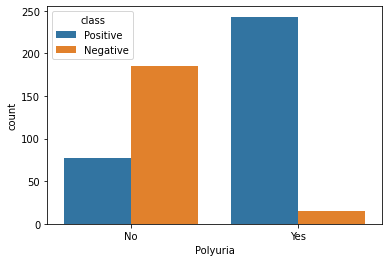

In [37]:
f_plot_column('Polyuria')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


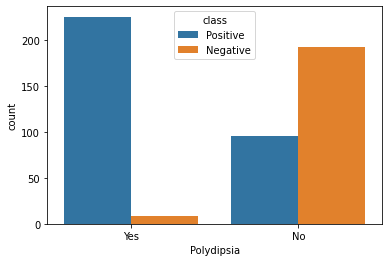

In [38]:
f_plot_column('Polydipsia')

In [39]:
# Data preprocessing
def f_normalize(df):
  # Convert Positive and Negative string to 0 and 1.
  df['class'] = df['class'].apply(lambda x: 0 if x=='Negative' else 1)
  le = LabelEncoder()
  objectList = df.select_dtypes(include = "object").columns
  for feature in objectList:
    # Convert Yes and No labels to 1,0
    df[feature] = le.fit_transform(df[feature].astype(str))
  return df

def f_feature_observed_split(df):
  return df.drop(['class'], axis=1), df['class']

In [40]:
df_norm = f_normalize(df)
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Age                 520 non-null    int64
 1   Gender              520 non-null    int64
 2   Polyuria            520 non-null    int64
 3   Polydipsia          520 non-null    int64
 4   sudden weight loss  520 non-null    int64
 5   weakness            520 non-null    int64
 6   Polyphagia          520 non-null    int64
 7   Genital thrush      520 non-null    int64
 8   visual blurring     520 non-null    int64
 9   Itching             520 non-null    int64
 10  Irritability        520 non-null    int64
 11  delayed healing     520 non-null    int64
 12  partial paresis     520 non-null    int64
 13  muscle stiffness    520 non-null    int64
 14  Alopecia            520 non-null    int64
 15  Obesity             520 non-null    int64
 16  class               520 non-null    int64
dt

In [41]:
# Remove classification from the training set
X,y = f_feature_observed_split(df_norm)

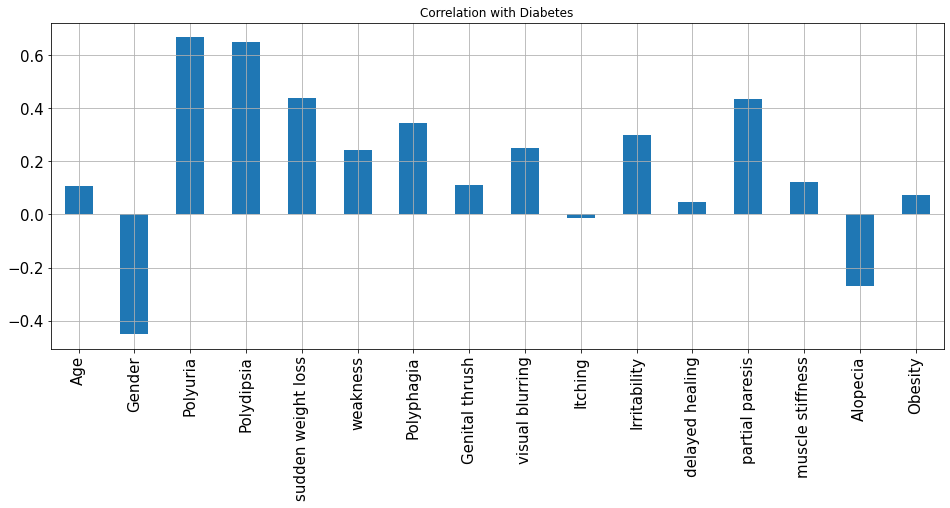

In [42]:
# Correlation with features
X.corrwith(y).plot.bar(
        figsize = (16, 6), title = "Correlation with Diabetes", fontsize = 15,
        rot = 90, grid = True)

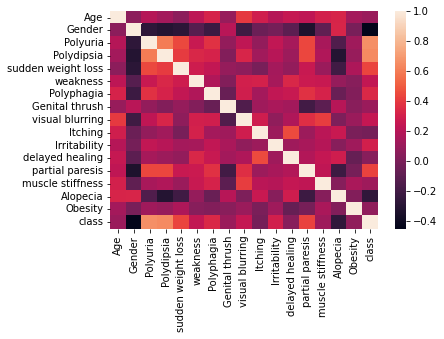

In [43]:
sns.heatmap(df.corr())

In [44]:
# Training and test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,stratify=y)
print('Training set')
print(y_train.value_counts())
print('Test set')
print(y_test.value_counts())

Training set
1    256
0    160
Name: class, dtype: int64
Test set
1    64
0    40
Name: class, dtype: int64


In [45]:
X_train.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
143,53,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0
466,38,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
286,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
436,41,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1
430,32,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1


In [46]:
X_test.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
367,40,0,1,1,1,1,0,0,1,0,0,1,1,1,0,0
491,53,1,0,0,0,1,1,0,1,1,0,1,1,1,1,0
227,30,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
379,62,1,1,1,0,0,1,0,1,0,1,1,1,0,1,0
285,30,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
def f_model_train_and_test(model, X_train, X_test, y_train, y_test):
  start = datetime.now()
  model_performance = 0.0
  y_test  = np.reshape(y_test, len(y_test), )
  y_train = np.reshape(y_train, len(y_train), )
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  model_performance = accuracy_score(y_test, y_pred)
  print(classification_report(y_test, y_pred))
  return model_performance.round(3), (datetime.now()-start).total_seconds()

In [48]:
print('Model performance without feature engineering.\n')
status_bayes, train_time =  f_model_train_and_test(GaussianNB(), X_train, X_test, y_train, y_test)
print('Bayes model performance = ', status_bayes)

status_svm, train_time =  f_model_train_and_test(SVC(), X_train, X_test, y_train, y_test)
print('SVM model performance   = ', status_svm)

status_dt, train_time =  f_model_train_and_test(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)
print('DTree model performance = ', status_dt)

status_knn, train_time =  f_model_train_and_test(KNeighborsClassifier(), X_train, X_test, y_train, y_test)
print('KNN model performance   = ', status_knn)

status_xgb, train_time =  f_model_train_and_test(XGBClassifier(), X_train, X_test, y_train, y_test)
print('XGBoost model performance   = ', status_xgb)

Model performance without feature engineering.

              precision    recall  f1-score   support

           0       0.88      0.95      0.92        40
           1       0.97      0.92      0.94        64

    accuracy                           0.93       104
   macro avg       0.93      0.94      0.93       104
weighted avg       0.94      0.93      0.93       104

Bayes model performance =  0.933
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.62      1.00      0.76        64

    accuracy                           0.62       104
   macro avg       0.31      0.50      0.38       104
weighted avg       0.38      0.62      0.47       104

SVM model performance   =  0.615
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        40
           1       1.00      0.95      0.98        64

    accuracy                           0.97       104
   macro avg  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
#Function to create squares for chi square testing
def make_squares(df, y):
  
  squares = []
  
  for feature in df.columns:
    #Age is unsuited for chi2 testing, and is removed
    if feature == 'Age' or feature == 'class':
      continue
    #Creates 2x2 matrices for each feature in chi square testing
    squares.append([[0,0],
                    [0,0]])
    for index in df.index:
      squares[-1][df.at[index,feature]][y[index]] += 1
    
  return squares

#Divides a feature into two seperate categories based on y = yes or no
#Used for preparing for anova testing
def split_feature(feature, y):
  positive = []
  negative = []
  for i in range(0, len(feature)):
    if y[i] == 1:
      positive.append(feature[i])
    else:
      negative.append(feature[i])
  return positive, negative

In [50]:
# Feature Engineering
#Create Chi squares for feature evaluation
x2_validation = make_squares(df_norm, y)
p_feature_tuples = []
#Test each feature, except age, and add that feature and its signifcance to list
for i in range(0, len(x2_validation)):
  chiValue = chisquare(x2_validation[i])
  print(f"{df.columns[i+1]} chi2 value: {chiValue[0][0]}, p value: {chiValue[1][0]}")
  p_feature_tuples.append([chiValue[1][0], df.columns[i+1]])

#Test age, then add it to the list
age_t, age_f = split_feature(df['Age'], df['class'])
#print(age_t, age_f)
age_validation = f_oneway(age_t, age_f)
p_feature_tuples.append([age_validation[1], df.columns[0]])
print(f"{df.columns[0]} F value: {age_validation[0]}, p value: {age_validation[1]}")

#Sort features from highest p value (most likely to be chance) to lowest
p_feature_tuples.sort(reverse = True)

Gender chi2 value: 131.22, p value: 2.2163085720657575e-30
Polyuria chi2 value: 144.5, p value: 2.7623240713337928e-33
Polydipsia chi2 value: 169.28, p value: 1.0627315595404882e-38
sudden weight loss chi2 value: 100.82, p value: 1.0073402520858437e-23
weakness chi2 value: 3.38, p value: 0.06599205505934735
Polyphagia chi2 value: 54.08, p value: 1.924906109997234e-13
Genital thrush chi2 value: 89.78, p value: 2.6617145763765865e-21
visual blurring chi2 value: 35.28, p value: 2.8554941795921847e-09
Itching chi2 value: 0.02, p value: 0.887537083981715
Irritability chi2 value: 141.12, p value: 1.5146153527973263e-32
delayed healing chi2 value: 3.92, p value: 0.04771488023735101
partial paresis chi2 value: 92.48, p value: 6.80086056533123e-22
muscle stiffness chi2 value: 32.0, p value: 1.5417257900280013e-08
Alopecia chi2 value: 0.02, p value: 0.887537083981715
Obesity chi2 value: 106.58, p value: 5.5025737506918925e-25
Age F value: 6.19128869030696, p value: 0.013151253540114654


In [51]:
X_train_selected = X_train.copy()
X_test_selected = X_test.copy()

p = .05
for feature in p_feature_tuples:
  if feature[0] > p:
    X_train_selected = X_train_selected.drop(feature[1], axis=1)
    X_test_selected = X_test_selected.drop(feature[1], axis=1)

print(X_test_selected)


     Age  Gender  Polyuria  Polydipsia  sudden weight loss  Polyphagia  \
367   40       0         1           1                   1           0   
491   53       1         0           0                   0           1   
227   30       1         0           0                   1           0   
379   62       1         1           1                   0           1   
285   30       1         0           0                   0           0   
..   ...     ...       ...         ...                 ...         ...   
48    35       0         1           1                   1           1   
385   38       1         1           0                   0           0   
460   47       1         0           0                   0           0   
289   40       1         0           0                   1           0   
196   66       1         0           0                   0           1   

     Genital thrush  visual blurring  Irritability  delayed healing  \
367               0                1    

In [52]:
# Retrain models
print('Model performance with feature engineering.\n')
f_status_bayes, tt_bayes =  f_model_train_and_test(GaussianNB(), X_train_selected, X_test_selected, y_train, y_test)
print('Bayes model performance = ', f_status_bayes)

f_status_svm, tt_svm =  f_model_train_and_test(SVC(), X_train_selected, X_test_selected, y_train, y_test)
print('SVM model performance   = ', f_status_svm)

f_status_dt, tt_dt =  f_model_train_and_test(DecisionTreeClassifier(), X_train_selected, X_test_selected, y_train, y_test)
print('DTree model performance = ', f_status_dt)

f_status_knn, tt_knn =  f_model_train_and_test(KNeighborsClassifier(), X_train_selected, X_test_selected, y_train, y_test)
print('KNN model performance   = ', f_status_knn)

f_status_xgb, tt_xgb =  f_model_train_and_test(XGBClassifier(), X_train_selected, X_test_selected, y_train, y_test)
print('XGBoost model performance   = ', f_status_xgb)

Model performance with feature engineering.

              precision    recall  f1-score   support

           0       0.88      0.95      0.92        40
           1       0.97      0.92      0.94        64

    accuracy                           0.93       104
   macro avg       0.93      0.94      0.93       104
weighted avg       0.94      0.93      0.93       104

Bayes model performance =  0.933
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.62      1.00      0.76        64

    accuracy                           0.62       104
   macro avg       0.31      0.50      0.38       104
weighted avg       0.38      0.62      0.47       104

SVM model performance   =  0.615
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        40
           1       1.00      0.95      0.98        64

    accuracy                           0.97       104
   macro avg     

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
info = [['Bayes', f_status_bayes, status_bayes, tt_bayes],
        ['SVM', f_status_svm, status_svm, tt_svm],
        ['Decision Tree', f_status_dt, status_dt, tt_dt],
        ['KNN', f_status_knn, status_knn, tt_knn],
        ['XGB (Extreme Gradient Boost)', f_status_xgb, status_xgb, tt_xgb],
        ]

info_df = pd.DataFrame(info, columns=['Algorithm', 'Accuracy', 'Accuracy Without Feature Selction', 'Time to Train (s)'])
info_df

,Algorithm,Accuracy,Accuracy Without Feature Selction,Time to Train (s)
0,Bayes,0.933,0.933,0.019936
1,SVM,0.615,0.615,0.029773
2,Decision Tree,0.971,0.971,0.013004
3,KNN,0.904,0.923,0.013382
4,XGB (Extreme Gradient Boost),0.981,0.971,0.048681
